In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from hybrid_model_v3 import HybridSegModel
from helper import postprocess_logits_with_fill

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F

In [2]:
# image_size = 128
# inference_name = "hybrid_model_ge(nodule_gland)_benq(gland)_from_scratch_v1_aug_space(0.9)"
# # inference_name = "from_scratch"
# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"../../code/models/finetune/ge_benq/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to("cuda")

In [3]:
image_size = 128

inference_name = "hybrid_model_ge(nodule_gland_inference)_benq(gland)_from_scratch_v3_1_aug_space(0.9)_weight_decay(1e-4)"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"../../code/models/from_scratch/ge_benq_inference/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

# inference_name = "hybrid_model_ge(nodule_gland)_benq(gland)_from_scratch_v1_aug_space(0.9)_weight_decay(1e-4)"
# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"../../code/models/from_scratch/ge_benq/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
model.to("cuda")

HybridSegModel(
  (backbone): HarDNetBackbone(
    (base_conv_1): ConvLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (base_conv_2): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (base_max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (hardblock): HarDBlock(
          (layers): ModuleList(
            (0): ConvLayer(
              (conv): Conv2d(64, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (norm): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [4]:
image_dir = os.listdir("crop_images/")
print(len(image_dir))

110


In [6]:
from torchvision.transforms.functional import to_pil_image

def overlay(image, mask):
    image_rgb = image.repeat(3, 1, 1)  # shape: [3, H, W]

    # Create red overlay where mask == 1
    # (Red channel = 1, Green = 0, Blue = 0)
    red = torch.tensor([1.0, 0.0, 0.0]).view(3, 1, 1)
    color_mask = mask * red  # shape: [3, H, W]
    
    # Blend mask onto image
    alpha = 0.8  # transparency
    overlay = (1 - alpha) * image_rgb + alpha * color_mask
    return overlay

# inference all videos

In [12]:
data_root = "crop_images"
video_dir = os.listdir(data_root)
for video_name in tqdm(video_dir):

    print(video_name)
    image_dir = sorted(os.listdir(f"{data_root}/{video_name}"))
    if '.ipynb_checkpoints' == image_dir[0]:
        image_dir = image_dir[1:]
    image_dir = sorted(image_dir, key=lambda x: int(x.split('.')[0]))
    print(len(image_dir))
    count = 0
    for i in (range(len(image_dir))):
        image_name = image_dir[i]
        if not "png" in image_name:
            continue
        image_path = f"{data_root}/{video_name}/{image_name}"
        image = Image.open(image_path).convert("L")
    
        resize = T.Resize((image_size, image_size))
        image = resize(image)
    
        image_tensor = tx.to_tensor(image)
        # If standardization
        mean = image_tensor.mean()
        std = image_tensor.std()
        std = std if std > 0 else 1.0  # avoid division by zero
        image_tensor = (image_tensor - mean) / std
        image = image_tensor.unsqueeze(0)
        image = image.to("cuda")
        output = model(image)
        
        nodule_output = output[:, 0:1]
        gland_output = output[:, 1:2]
    
        # nodule_output = torch.sigmoid(nodule_output)
        nodule_process = postprocess_logits_with_fill(nodule_output, 0.9)
        
        nodule_output = torch.sigmoid(nodule_output)
        nodule_output = nodule_output > 0.99
    
        gland_output = postprocess_logits_with_fill(gland_output, 0.9)
        gland_output = gland_output > 0.99
        
        # print(gland_output.shape)
    
        nodule_image = Image.fromarray(nodule_output[0][0].detach().cpu().numpy())
        gland_image = Image.fromarray(gland_output[0][0].detach().cpu().numpy())
        
        
        folder = "from_scratch_inference_masks_test_v3_1_aug_space(0.9)_weight_decay(1e-4)"
        video_path = f"{folder}/{video_name}/"
        nodule_path = f"{folder}/{video_name}/nodule/"
        gland_path = f"{folder}/{video_name}/gland/"
        combine_nodule_path = f"{folder}/{video_name}/combine_nodule/"
        combine_gland_path = f"{folder}/{video_name}/combine_gland/"
        
        # if not os.path.exists(nodule_path):
        os.makedirs(video_path, exist_ok=True)
        os.makedirs(nodule_path, exist_ok=True)
        os.makedirs(gland_path, exist_ok=True)
        os.makedirs(combine_nodule_path, exist_ok=True)
        os.makedirs(combine_gland_path, exist_ok=True)
            
        

        nodule_output = nodule_output.squeeze(0).float()
        gland_output = gland_output.squeeze(0).float()
        image = image.to("cpu")
        nodule_output = nodule_output.to("cpu")
        gland_output = gland_output.to("cpu")
        nodule_overlay = overlay(image.squeeze(0), nodule_output)
        gland_overlay = overlay(image.squeeze(0), gland_output)

        # plt.figure(figsize = (20, 20))
        # plt.subplot(1,3,1)
        # plt.imshow(image[0][0])
        # plt.title("image")
        # plt.subplot(1,3,2)
        # plt.imshow(nodule_overlay[0])
        # plt.title("nodule overlay")
        # plt.subplot(1,3,3)
        # plt.imshow(gland_overlay[0])
        # plt.title("gland overlay")
        # plt.show()
        
        nodule_overlay = (nodule_overlay - nodule_overlay.min()) / (nodule_overlay.max() - nodule_overlay.min())
        gland_overlay = (gland_overlay - gland_overlay.min()) / (gland_overlay.max() - gland_overlay.min())
        
        nodule_overlay_image = to_pil_image(nodule_overlay)
        gland_overlay_image = to_pil_image(gland_overlay)

        nodule_image.save(nodule_path + image_name)
        gland_image.save(gland_path + image_name)
        nodule_overlay_image.save(combine_nodule_path + image_name)
        gland_overlay_image.save(combine_gland_path + image_name)
        
        # plt.imshow(image[0][0].detach().cpu().numpy())
        # plt.imshow(nodule_output[0][0].detach().cpu().numpy(), alpha = 0.3)
        # plt.axis('off')
        # plt.savefig(f"{combine_nodule_path}/{image_name}", bbox_inches='tight', pad_inches=0)
        # # plt.show()
        # plt.close()
    
        # plt.imshow(image[0][0].detach().cpu().numpy())
        # plt.imshow(gland_output[0][0].detach().cpu().numpy(), alpha = 0.3)
        # plt.axis('off')
        # plt.savefig(f"{combine_gland_path}/{image_name}", bbox_inches='tight', pad_inches=0)
        # # plt.show()
        # plt.close()
        # break
        # if count%20 == 0:
        #     print(video_name + "/" + image_name)
        #     plt.figure(figsize = (20, 20))
        #     plt.subplot(1,5,1)
        #     plt.imshow(image[0].detach().cpu().numpy())
        #     plt.title("image")
        #     plt.subplot(1,5,2)
        #     plt.imshow(nodule_output[0].detach().cpu().numpy())
        #     plt.title("nodule pred")
            
        #     plt.subplot(1,5,3)
        #     plt.imshow(image[0][0].detach().cpu().numpy())
        #     plt.imshow(nodule_output[0][0].detach().cpu().numpy(), alpha = 0.5)
        #     plt.title("nodule on image")
            
        #     plt.subplot(1,5,4)
        #     plt.imshow(nodule_process[0][0].detach().cpu().numpy())
        #     plt.title("nodule processed")
        #     plt.subplot(1,5,5)
        #     plt.imshow(gland_output[0][0].detach().cpu().numpy())
        #     plt.title("gland pred")
        #     plt.show()
        count+=1
        # if count > 30:
        #     break
    # break

  0%|          | 0/110 [00:00<?, ?it/s]

video_000060_1743042450542
98


  1%|          | 1/110 [00:17<32:15, 17.76s/it]

video_000054_1743039765520
99


  2%|▏         | 2/110 [00:32<28:43, 15.96s/it]

video_000041_1734082940591.MP4
198


  3%|▎         | 3/110 [01:02<40:19, 22.61s/it]

video_000096_1742815518189
198


  4%|▎         | 4/110 [01:40<50:12, 28.42s/it]

video_000055_1743040268561
98


  5%|▍         | 5/110 [01:55<41:41, 23.82s/it]

video_000095_1742815155234
178


  5%|▌         | 6/110 [02:20<41:51, 24.15s/it]

video_000070_1743153344891
98


  6%|▋         | 7/110 [02:26<30:56, 18.02s/it]

video_000041_1734082965800.MP4
198


  7%|▋         | 8/110 [02:36<26:37, 15.66s/it]

video_000055_1743040240609
98


  8%|▊         | 9/110 [02:41<20:41, 12.30s/it]

video_000041_1734078834415.MP4
115


  9%|▉         | 10/110 [02:47<17:14, 10.35s/it]

video_000096_1742815834970
198


 10%|█         | 11/110 [02:58<17:10, 10.41s/it]

video_000096_1742815578237
198


 11%|█         | 12/110 [03:09<17:37, 10.79s/it]

video_000041_1734078135266.MP4
186


 12%|█▏        | 13/110 [03:19<17:00, 10.52s/it]

video_000096_1742815754024
199


 13%|█▎        | 14/110 [03:29<16:37, 10.39s/it]

video_000059_1743041664581
98


 14%|█▎        | 15/110 [03:34<13:53,  8.77s/it]

video_000067_1743151221301
98


 15%|█▍        | 16/110 [03:39<11:54,  7.60s/it]

video_000055_1743040259077
98


 15%|█▌        | 17/110 [03:44<10:36,  6.84s/it]

video_000079_1739886019329.MP4
198


 16%|█▋        | 18/110 [03:53<11:25,  7.45s/it]

video_000041_1734078184914.MP4
168


 17%|█▋        | 19/110 [04:02<12:05,  7.97s/it]

video_000054_1743039757213
98


 18%|█▊        | 20/110 [04:08<10:40,  7.12s/it]

video_000041_1734078157132.MP4
198


 19%|█▉        | 21/110 [04:18<12:02,  8.12s/it]

video_000095_1742815167049
142


 20%|██        | 22/110 [05:10<31:19, 21.36s/it]

video_000041_1734084360997.MP4
198


 21%|██        | 23/110 [06:05<45:18, 31.25s/it]

video_000095_1742815179107
162


 22%|██▏       | 24/110 [06:50<50:43, 35.39s/it]

video_000053_1743039079001
98


 23%|██▎       | 25/110 [07:21<48:26, 34.20s/it]

video_000079_1739887290160.MP4
198


 24%|██▎       | 26/110 [08:16<56:41, 40.49s/it]

video_000053_1743039094017
98


 25%|██▍       | 27/110 [08:41<49:35, 35.85s/it]

video_000068_1743152330551
88


 25%|██▌       | 28/110 [09:14<47:40, 34.89s/it]

video_000094_1742456908609
198


 26%|██▋       | 29/110 [10:11<56:12, 41.64s/it]

video_000054_1743039779048
99


 27%|██▋       | 30/110 [10:39<49:47, 37.34s/it]

video_000053_1743039034593
98


 28%|██▊       | 31/110 [11:06<45:13, 34.35s/it]

video_000041_1734080821337.MP4
198


 29%|██▉       | 32/110 [12:01<52:36, 40.47s/it]

video_000096_1742815775618
198


 30%|███       | 33/110 [12:58<58:16, 45.42s/it]

video_000094_1742456842154
198


 31%|███       | 34/110 [13:49<59:42, 47.13s/it]

video_000059_1743041676791
98


 32%|███▏      | 35/110 [14:14<50:53, 40.72s/it]

video_000055_1743040231873
98


 33%|███▎      | 36/110 [14:42<45:13, 36.67s/it]

video_000041_1734081487750.MP4
198


 34%|███▎      | 37/110 [15:36<51:06, 42.01s/it]

video_000070_1743153376960
98


 35%|███▍      | 38/110 [16:03<45:06, 37.59s/it]

video_000069_1743152972173
98


 35%|███▌      | 39/110 [16:31<40:55, 34.59s/it]

video_000057_1743041109150
98


 36%|███▋      | 40/110 [17:04<39:53, 34.20s/it]

video_000067_1743151246341
99


 37%|███▋      | 41/110 [17:29<36:09, 31.44s/it]

video_000041_1734078846344.MP4
174


 38%|███▊      | 42/110 [18:16<40:45, 35.97s/it]

video_000070_1743153365594
98


 39%|███▉      | 43/110 [18:38<35:30, 31.80s/it]

video_000053_1743039045191
98


 40%|████      | 44/110 [19:07<34:00, 30.92s/it]

video_000079_1739886150007.MP4
188


 41%|████      | 45/110 [19:57<39:53, 36.82s/it]

video_000096_1742815593333
188


 42%|████▏     | 46/110 [20:54<45:40, 42.83s/it]

video_000041_1734080852227.MP4
198


 43%|████▎     | 47/110 [21:43<46:45, 44.53s/it]

video_000060_1743042396933
98


 44%|████▎     | 48/110 [22:07<39:43, 38.44s/it]

video_000059_1743041709103
98


 45%|████▍     | 49/110 [22:36<36:15, 35.67s/it]

video_000095_1742815107664
175


 45%|████▌     | 50/110 [23:28<40:24, 40.41s/it]

video_000067_1743151203239
99


 46%|████▋     | 51/110 [23:58<36:51, 37.48s/it]

video_000041_1734082184755.MP4
131


 47%|████▋     | 52/110 [24:36<36:14, 37.49s/it]

video_000055_1743040250645
98


 48%|████▊     | 53/110 [25:06<33:26, 35.20s/it]

video_000067_1743151233880
68


 49%|████▉     | 54/110 [25:22<27:37, 29.60s/it]

video_000041_1734078875875.MP4
198


 50%|█████     | 55/110 [26:21<35:09, 38.35s/it]

video_000041_1734078171590.MP4
186


 51%|█████     | 56/110 [27:13<38:12, 42.45s/it]

video_000096_1742815545658
198


 52%|█████▏    | 57/110 [28:12<41:51, 47.39s/it]

video_000096_1742815500008
198


 53%|█████▎    | 58/110 [29:07<42:57, 49.58s/it]

video_000095_1742815205049
192


 54%|█████▎    | 59/110 [30:03<43:58, 51.73s/it]

video_000060_1743042459315
98


 55%|█████▍    | 60/110 [30:32<37:26, 44.94s/it]

video_000069_1743152963566
99


 55%|█████▌    | 61/110 [31:00<32:22, 39.64s/it]

video_000095_1742815238988
195


 56%|█████▋    | 62/110 [31:51<34:31, 43.15s/it]

video_000067_1743151195498
78


 57%|█████▋    | 63/110 [32:13<28:51, 36.84s/it]

video_000054_1743039804625
98


 58%|█████▊    | 64/110 [32:37<25:17, 33.00s/it]

video_000041_1734082157615.MP4
199


 59%|█████▉    | 65/110 [33:29<29:03, 38.74s/it]

video_000068_1743152360026
88


 60%|██████    | 66/110 [33:52<24:54, 33.97s/it]

video_000067_1743151263996
99


 61%|██████    | 67/110 [34:17<22:21, 31.20s/it]

video_000057_1743041143303
96


 62%|██████▏   | 68/110 [34:46<21:18, 30.43s/it]

video_000053_1743039060691
98


 63%|██████▎   | 69/110 [35:15<20:39, 30.23s/it]

video_000041_1734078824312.MP4
157


 64%|██████▎   | 70/110 [35:55<22:00, 33.01s/it]

video_000079_1739885918898.MP4
198


 65%|██████▍   | 71/110 [36:55<26:46, 41.20s/it]

video_000067_1743151254337
98


 65%|██████▌   | 72/110 [37:22<23:21, 36.89s/it]

video_000079_1739887938281.MP4
163


 66%|██████▋   | 73/110 [38:04<23:44, 38.51s/it]

video_000041_1734080877189.MP4
67


 67%|██████▋   | 74/110 [38:21<19:12, 32.02s/it]

video_000068_1743152396091
88


 68%|██████▊   | 75/110 [38:47<17:31, 30.03s/it]

video_000096_1742815698517
198


 69%|██████▉   | 76/110 [39:39<20:49, 36.75s/it]

video_000041_1734081520694.MP4
118


 70%|███████   | 77/110 [40:10<19:20, 35.16s/it]

video_000095_1742815257905
128


 71%|███████   | 78/110 [40:45<18:39, 34.97s/it]

video_000067_1743151228388
99


 72%|███████▏  | 79/110 [41:07<16:03, 31.09s/it]

video_000060_1743042417973
98


 73%|███████▎  | 80/110 [41:32<14:39, 29.33s/it]

video_000068_1743152411786
88


 74%|███████▎  | 81/110 [41:56<13:20, 27.59s/it]

video_000057_1743041153275
98


 75%|███████▍  | 82/110 [42:32<14:01, 30.05s/it]

video_000053_1743039104355
98


 75%|███████▌  | 83/110 [42:57<12:55, 28.73s/it]

video_000059_1743041717761
98


 76%|███████▋  | 84/110 [43:25<12:19, 28.45s/it]

video_000041_1734084373796.MP4
160


 77%|███████▋  | 85/110 [44:23<15:35, 37.44s/it]

video_000096_1742815811858
188


 78%|███████▊  | 86/110 [45:11<16:14, 40.60s/it]

video_000041_1734084405146.MP4
198


 79%|███████▉  | 87/110 [45:59<16:23, 42.74s/it]

video_000060_1743042439656
74


 80%|████████  | 88/110 [46:21<13:20, 36.37s/it]

video_000057_1743041135885
98


 81%|████████  | 89/110 [46:50<12:02, 34.39s/it]

video_000096_1742815728224
198


 82%|████████▏ | 90/110 [47:48<13:46, 41.32s/it]

video_000094_1742456812691
183


 83%|████████▎ | 91/110 [48:37<13:52, 43.80s/it]

video_000068_1743152473886
88


 84%|████████▎ | 92/110 [49:02<11:25, 38.07s/it]

video_000069_1743152945946
98


 85%|████████▍ | 93/110 [49:36<10:26, 36.86s/it]

video_000059_1743041687050
98


 85%|████████▌ | 94/110 [50:05<09:10, 34.43s/it]

video_000068_1743152443365
88


 86%|████████▋ | 95/110 [50:31<07:58, 31.87s/it]

video_000057_1743041119981
98


 87%|████████▋ | 96/110 [50:58<07:05, 30.36s/it]

video_000070_1743153351107
67


 88%|████████▊ | 97/110 [51:18<05:54, 27.24s/it]

video_000054_1743039788205
98


 89%|████████▉ | 98/110 [51:46<05:29, 27.47s/it]

video_000041_1734080836408.MP4
198


 90%|█████████ | 99/110 [52:47<06:53, 37.60s/it]

video_000095_1742815191197
154


 91%|█████████ | 100/110 [53:34<06:43, 40.33s/it]

video_000059_1743041697539
98


 92%|█████████▏| 101/110 [54:04<05:37, 37.49s/it]

video_000060_1743042383626
98


 93%|█████████▎| 102/110 [54:33<04:39, 34.89s/it]

video_000095_1742815248440
114


 94%|█████████▎| 103/110 [55:07<04:02, 34.60s/it]

video_000079_1739887959287.MP4
168


 95%|█████████▍| 104/110 [55:56<03:53, 38.92s/it]

video_000055_1743040277485
98


 95%|█████████▌| 105/110 [56:23<02:56, 35.37s/it]

video_000054_1743039796066
98


 96%|█████████▋| 106/110 [56:57<02:19, 34.77s/it]

video_000094_1742456881234
198


 97%|█████████▋| 107/110 [57:52<02:02, 40.96s/it]

video_000041_1734081510280.MP4
198


 98%|█████████▊| 108/110 [58:45<01:29, 44.62s/it]

video_000041_1734084389678.MP4
198


 99%|█████████▉| 109/110 [59:39<00:47, 47.46s/it]

video_000069_1743152954334
98


100%|██████████| 110/110 [1:00:02<00:00, 32.75s/it]


# inference one video

video_000041_1734078824312.MP4
157
video_000041_1734078824312.MP4/0.png


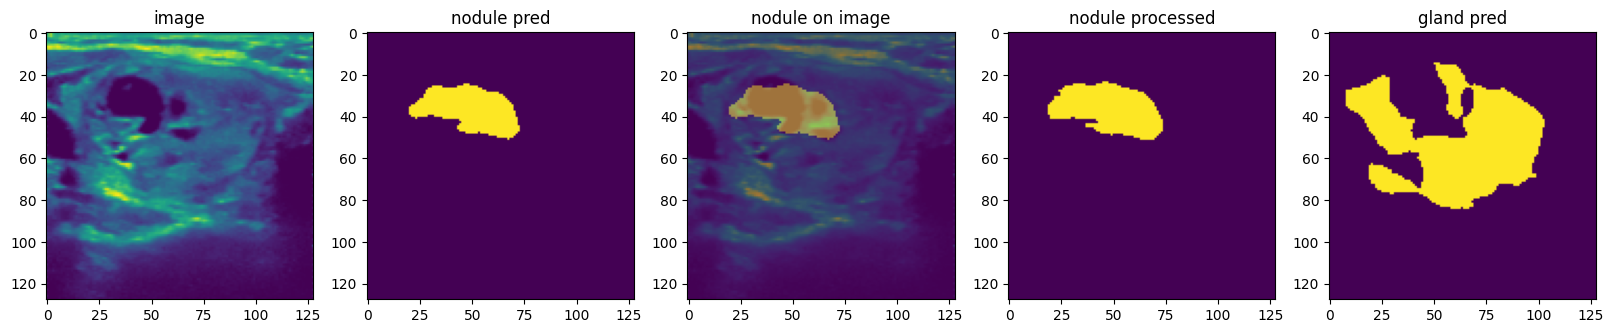

video_000041_1734078824312.MP4/5.png


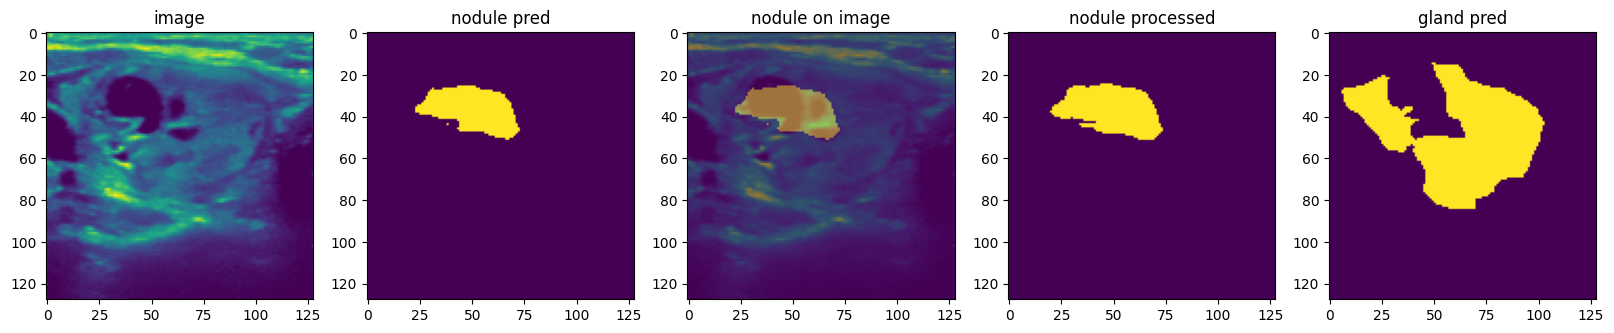

video_000041_1734078824312.MP4/10.png


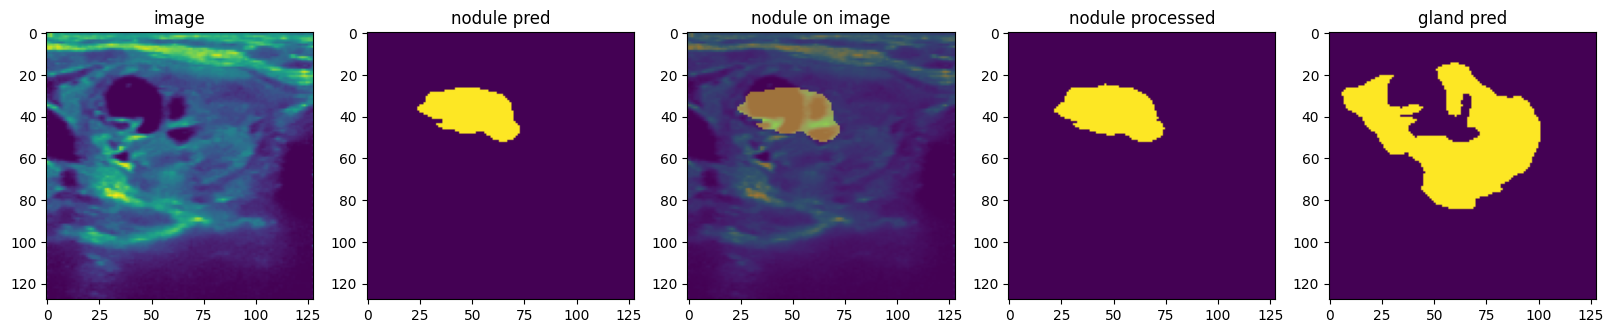

video_000041_1734078824312.MP4/15.png


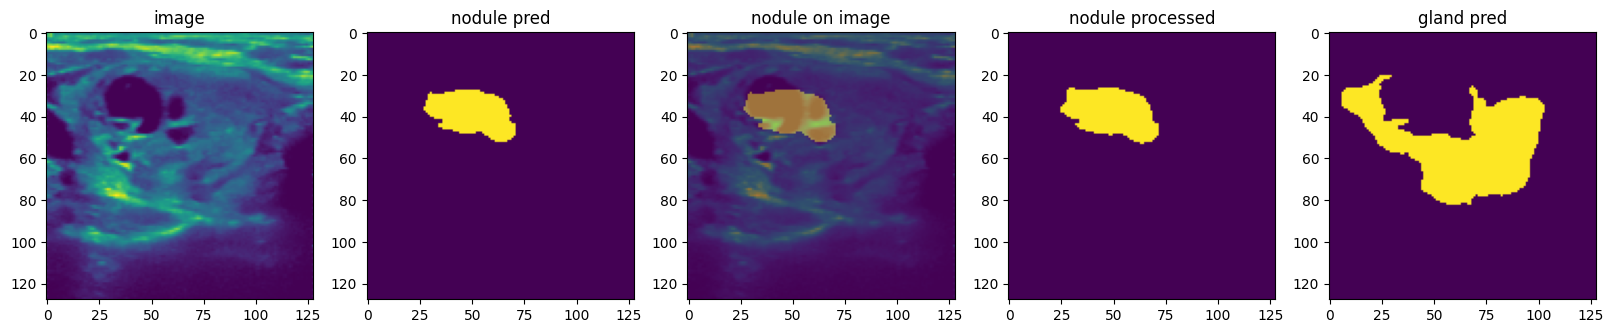

video_000041_1734078824312.MP4/20.png


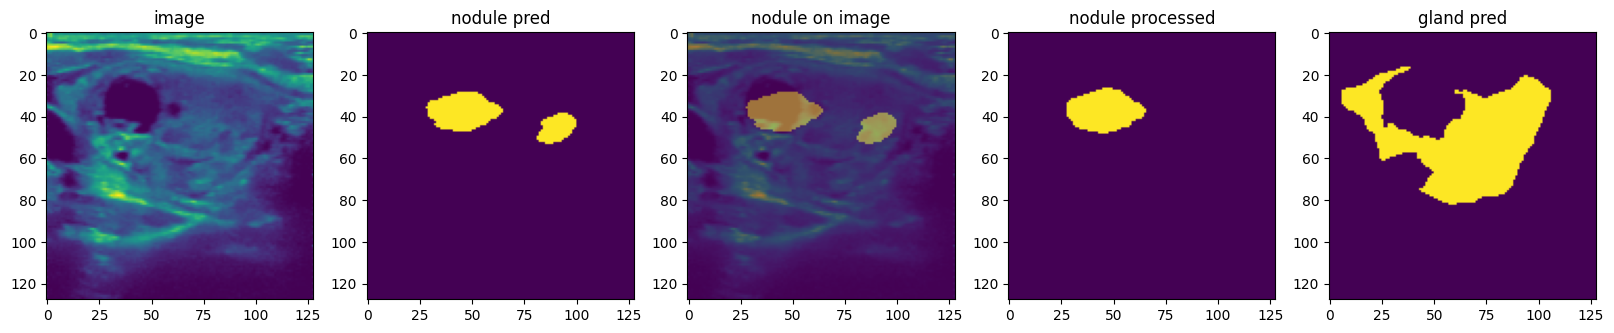

video_000041_1734078824312.MP4/25.png


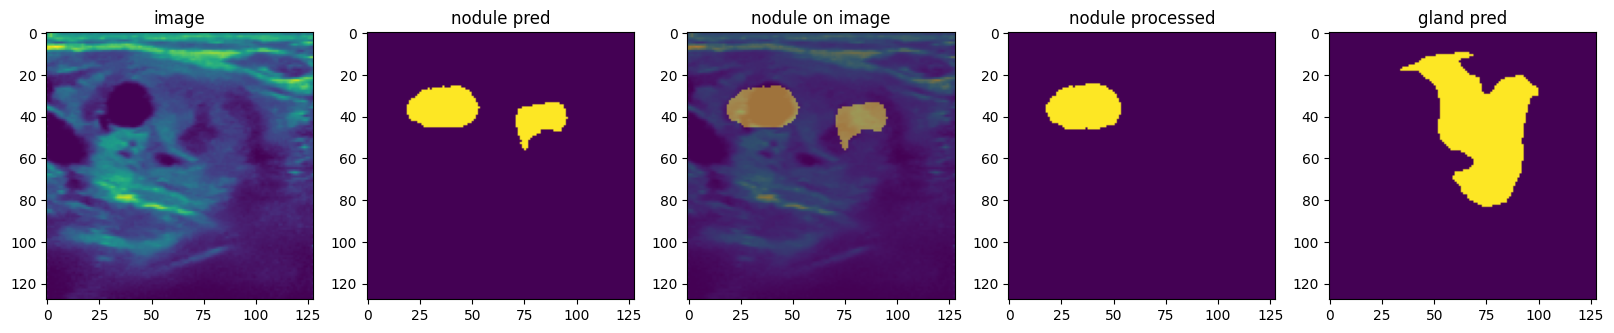

video_000041_1734078824312.MP4/30.png


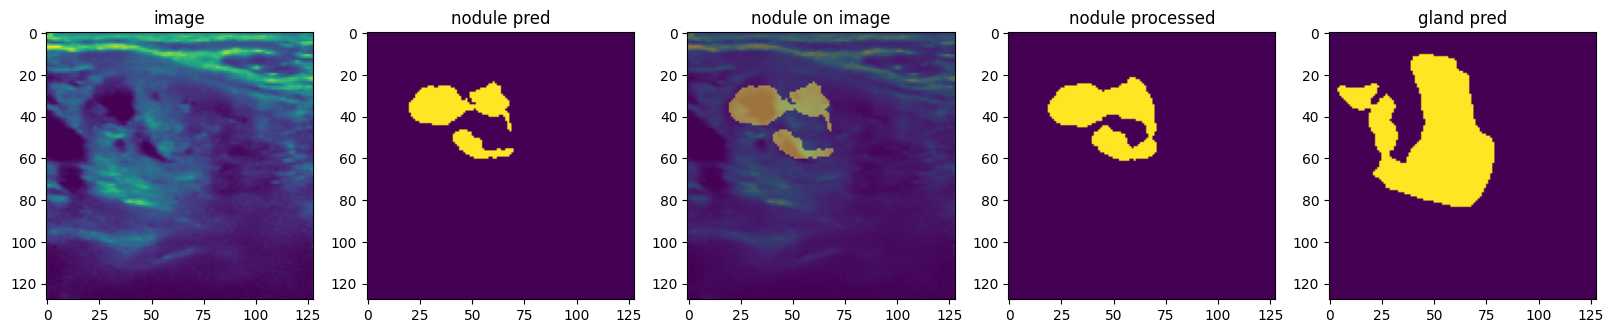

video_000041_1734078824312.MP4/35.png


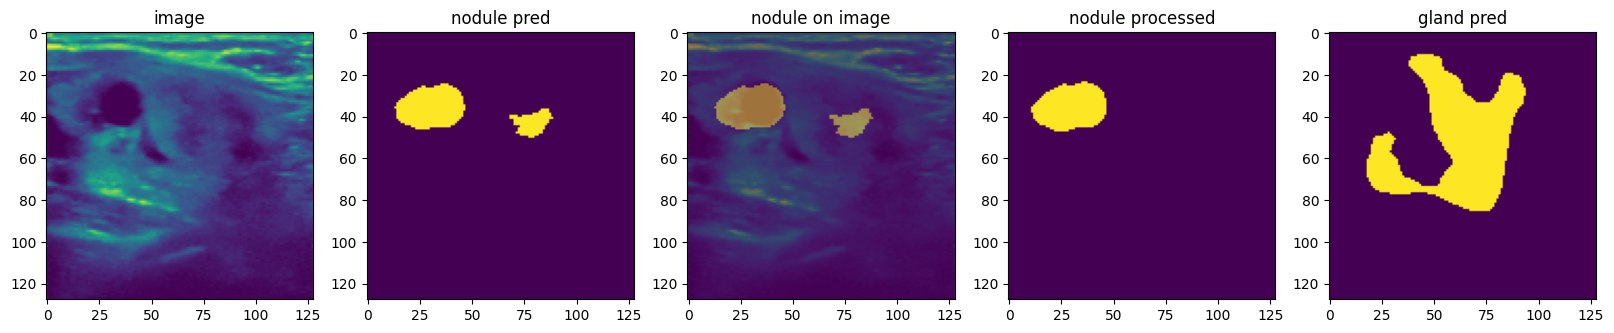

video_000041_1734078824312.MP4/40.png


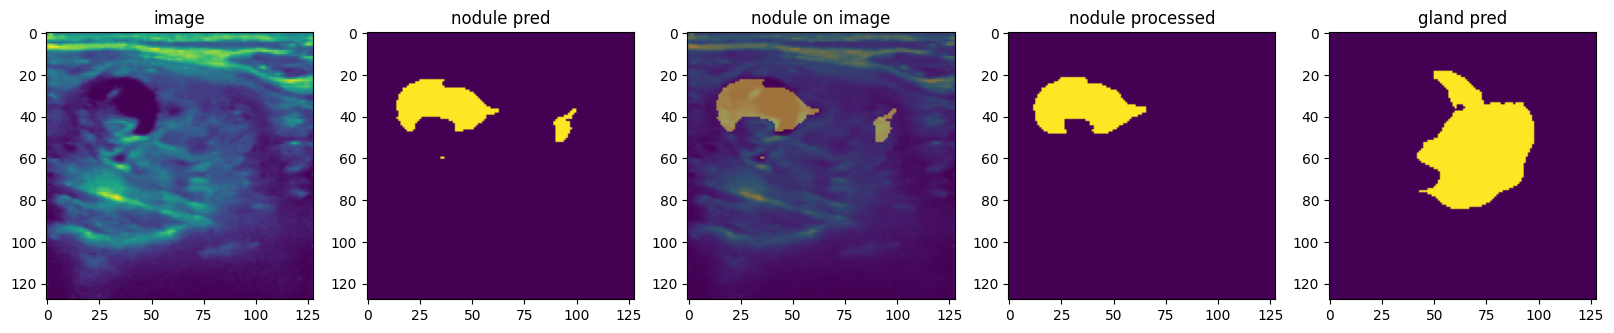

video_000041_1734078824312.MP4/45.png


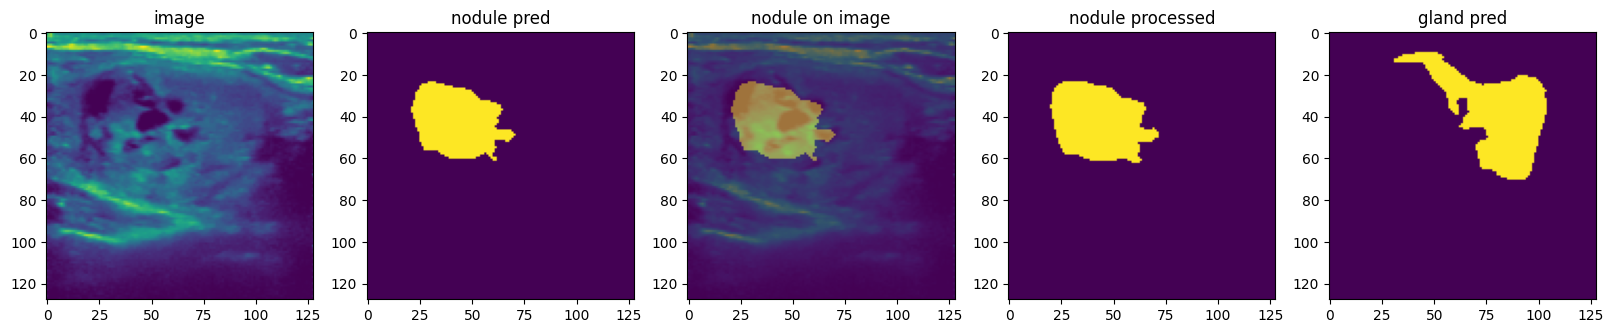

video_000041_1734078824312.MP4/50.png


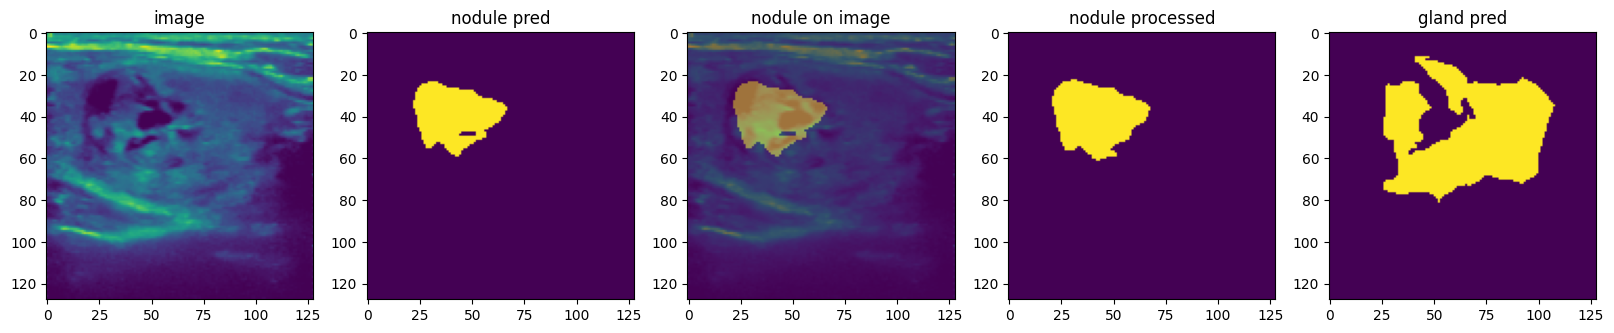

video_000041_1734078824312.MP4/55.png


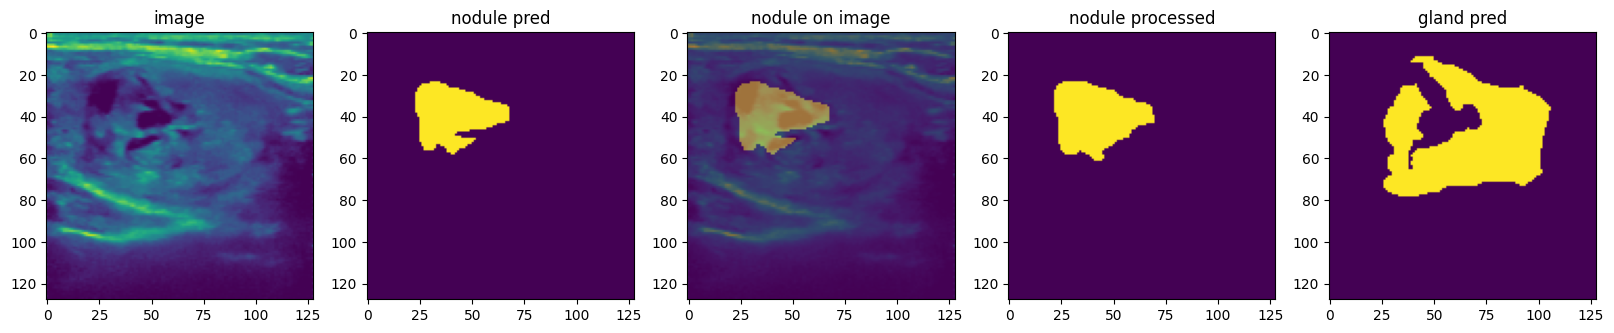

video_000041_1734078824312.MP4/60.png


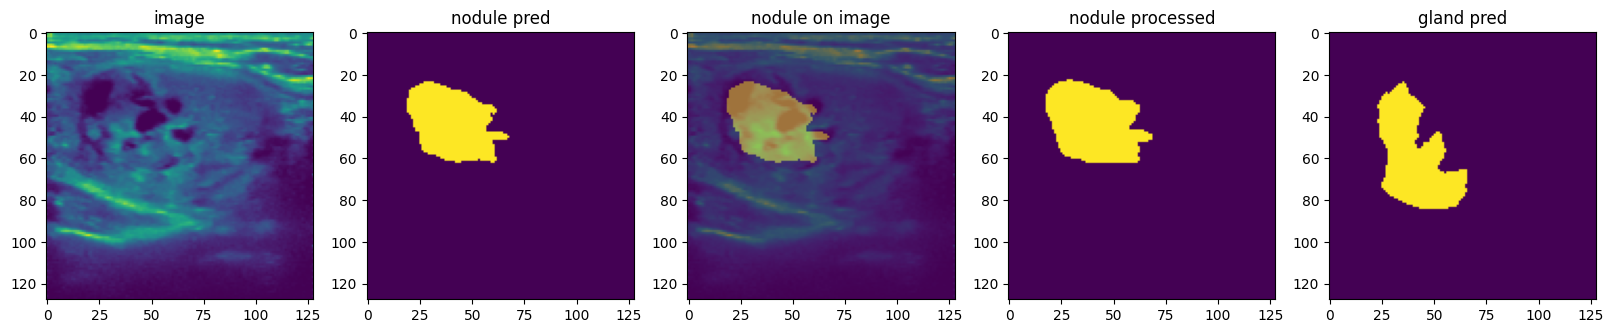

video_000041_1734078824312.MP4/65.png


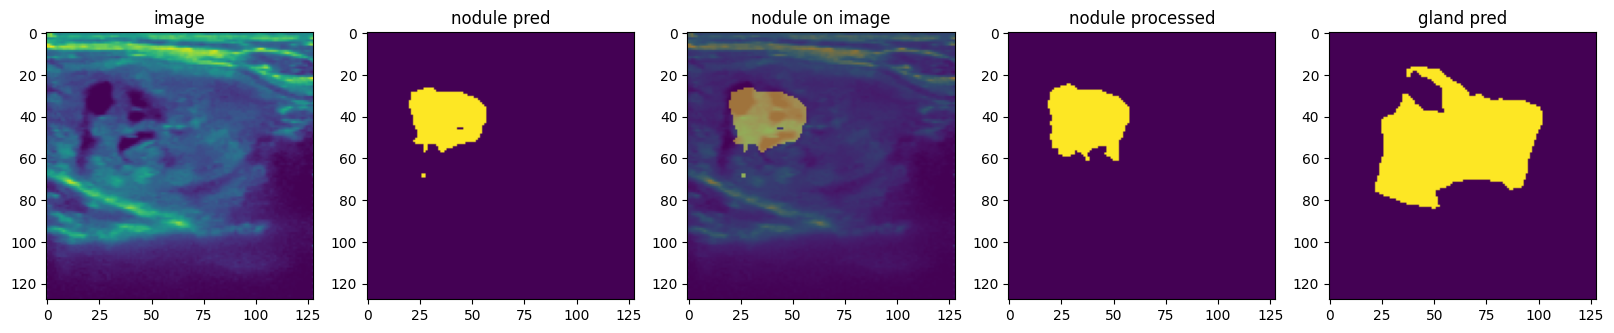

video_000041_1734078824312.MP4/70.png


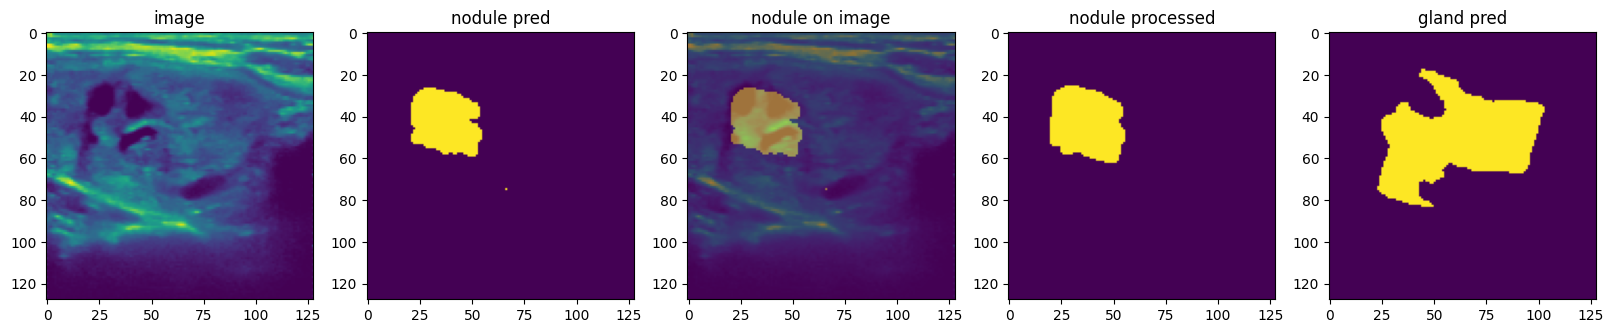

video_000041_1734078824312.MP4/75.png


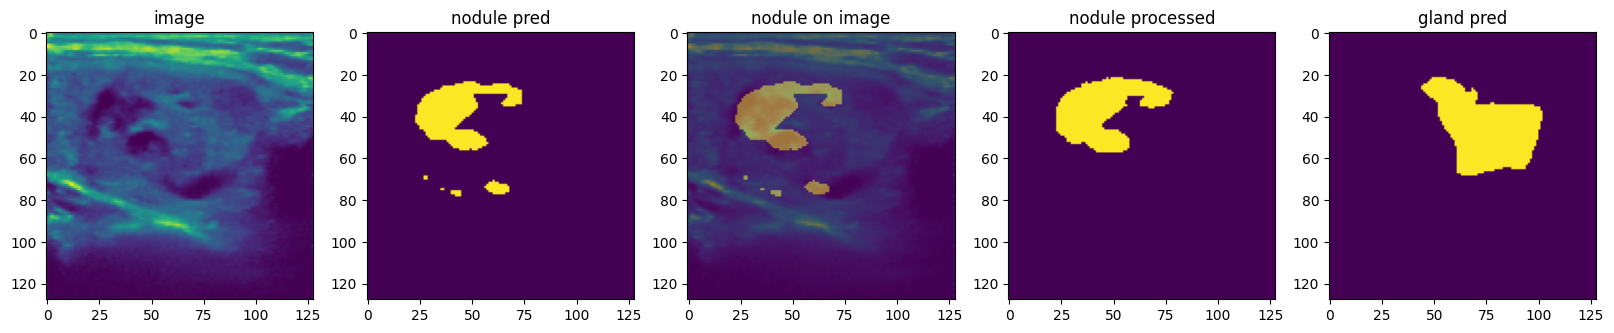

video_000041_1734078824312.MP4/80.png


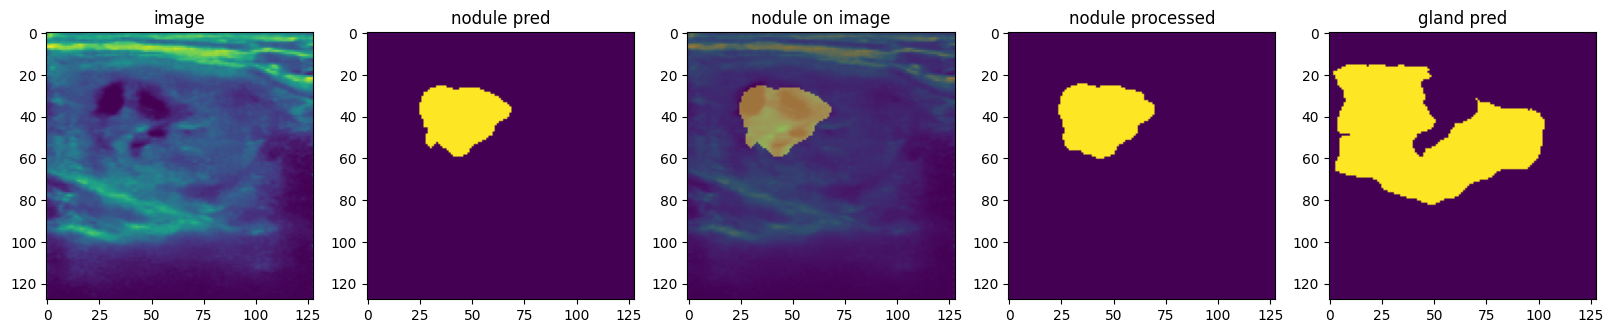

video_000041_1734078824312.MP4/85.png


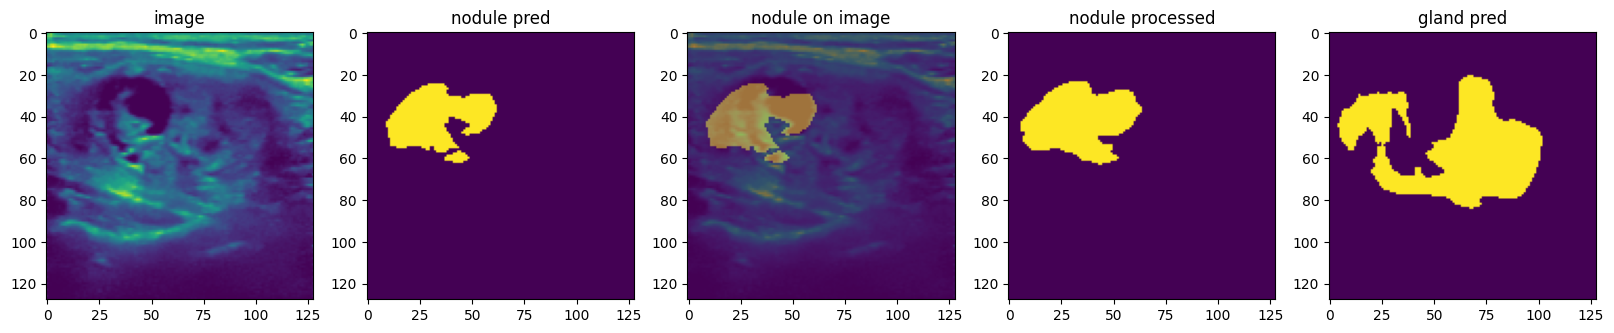

video_000041_1734078824312.MP4/90.png


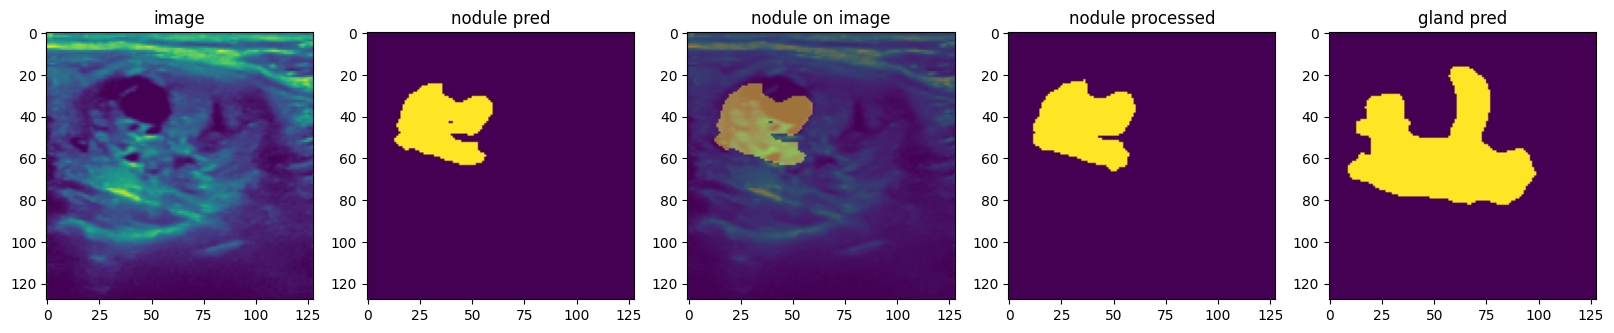

video_000041_1734078824312.MP4/95.png


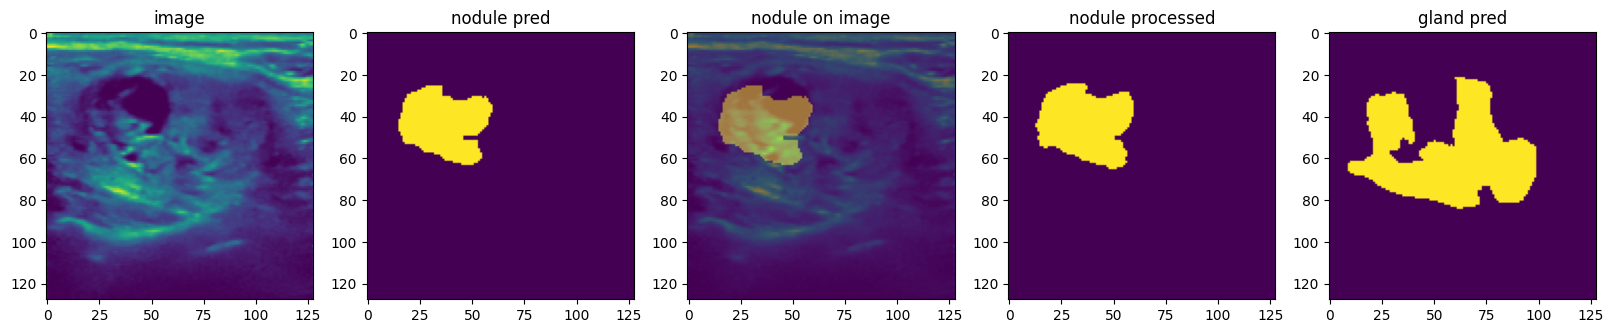

video_000041_1734078824312.MP4/100.png


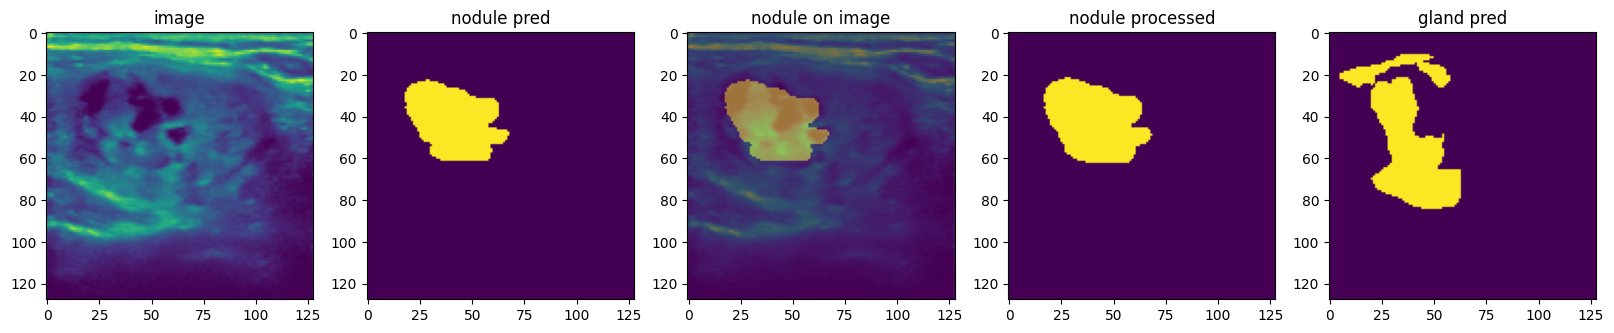

video_000041_1734078824312.MP4/105.png


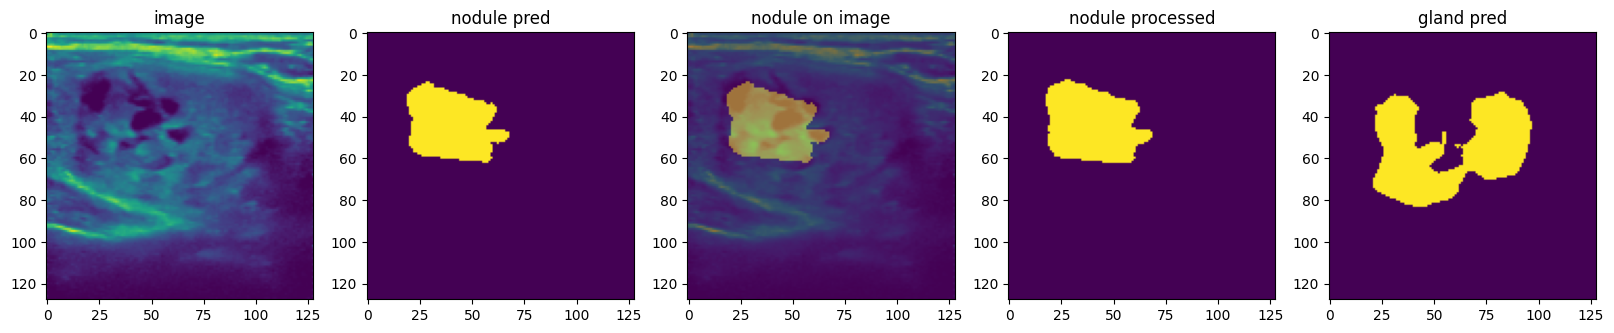

video_000041_1734078824312.MP4/110.png


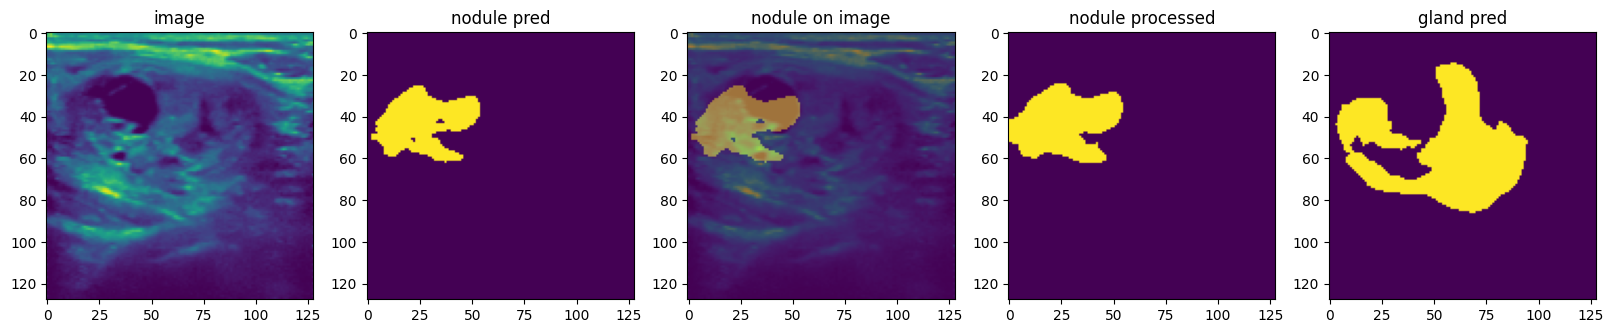

video_000041_1734078824312.MP4/115.png


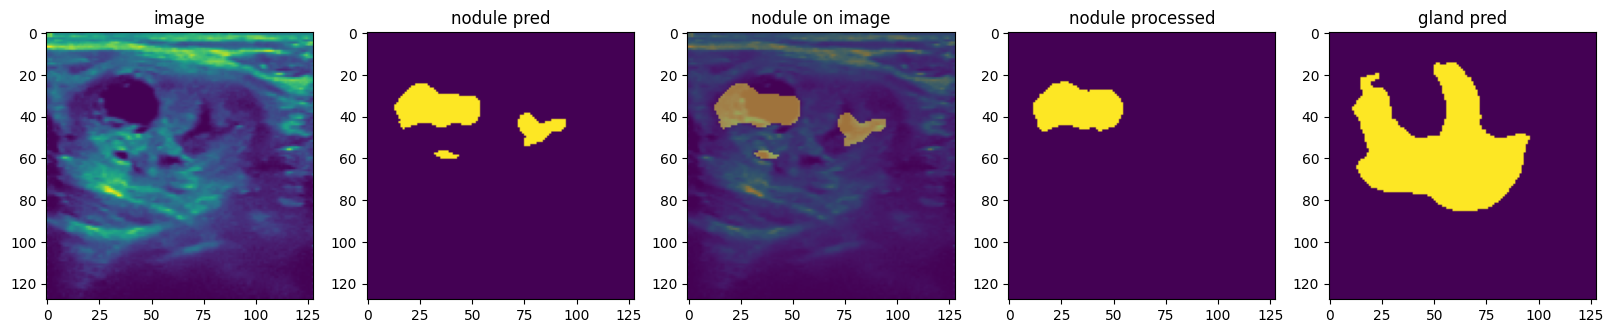

video_000041_1734078824312.MP4/120.png


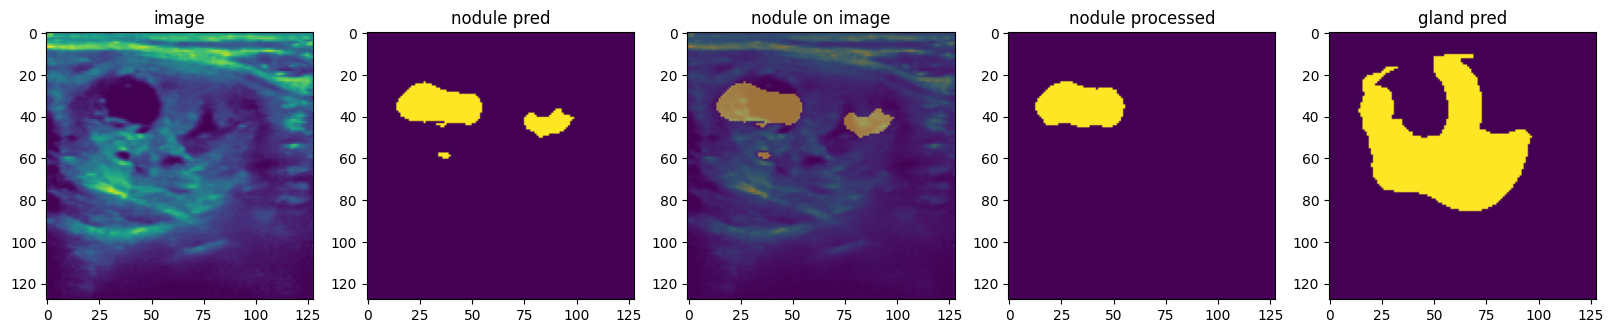

video_000041_1734078824312.MP4/125.png


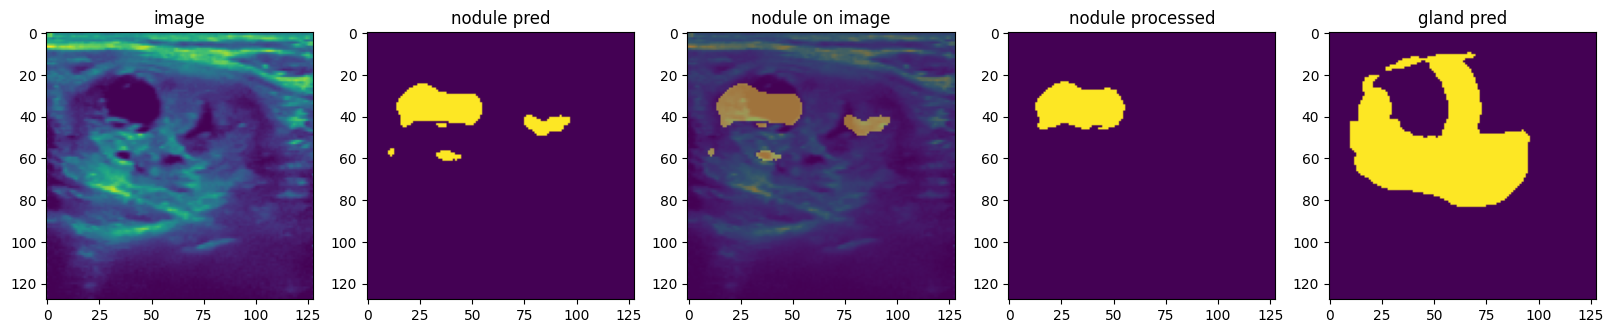

video_000041_1734078824312.MP4/130.png


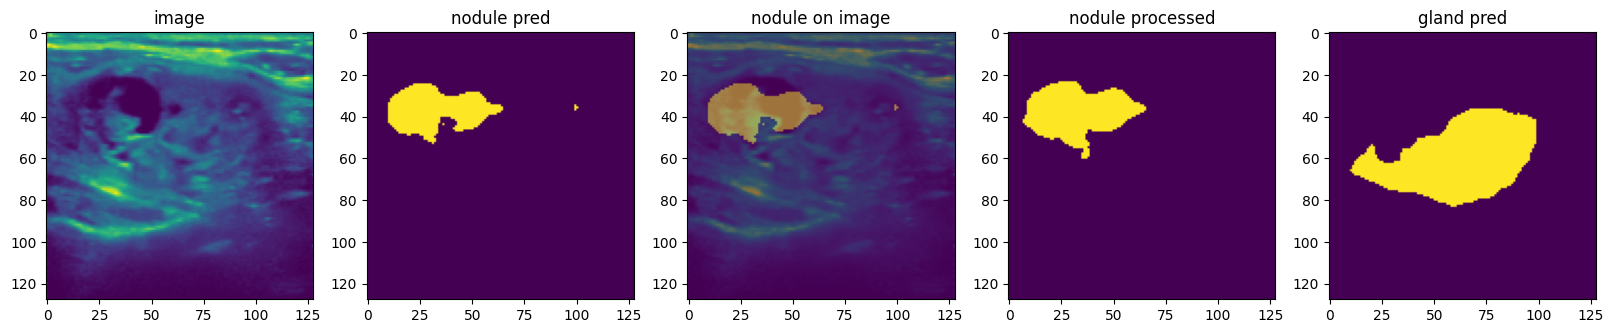

video_000041_1734078824312.MP4/135.png


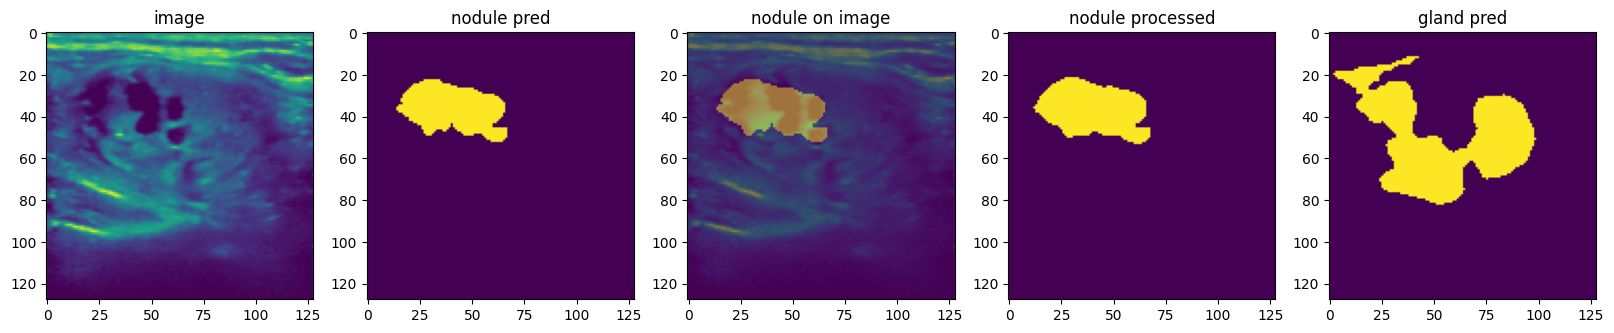

video_000041_1734078824312.MP4/140.png


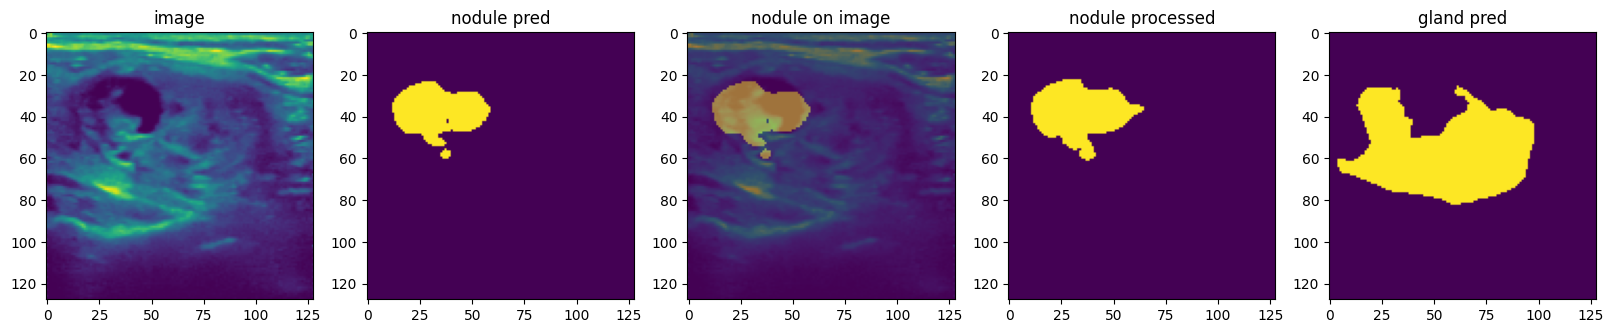

video_000041_1734078824312.MP4/145.png


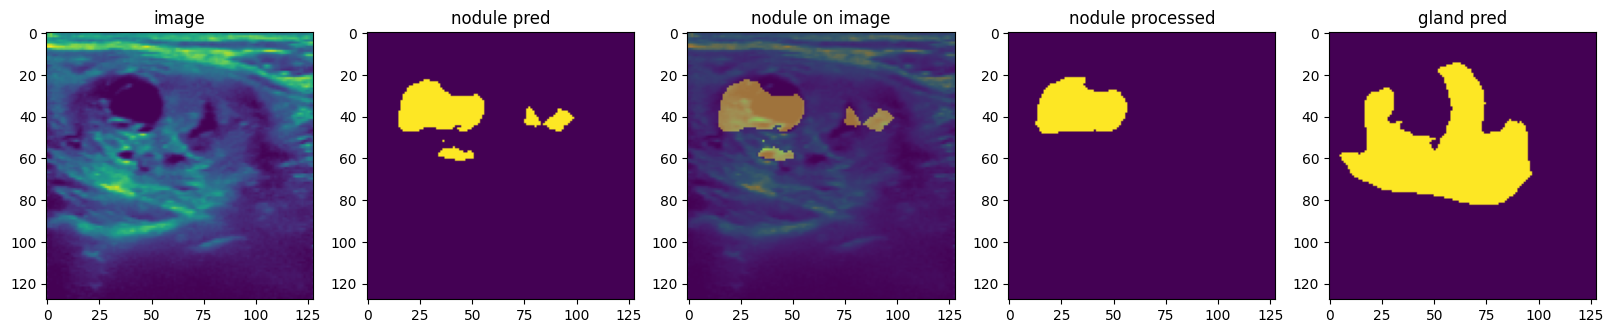

video_000041_1734078824312.MP4/150.png


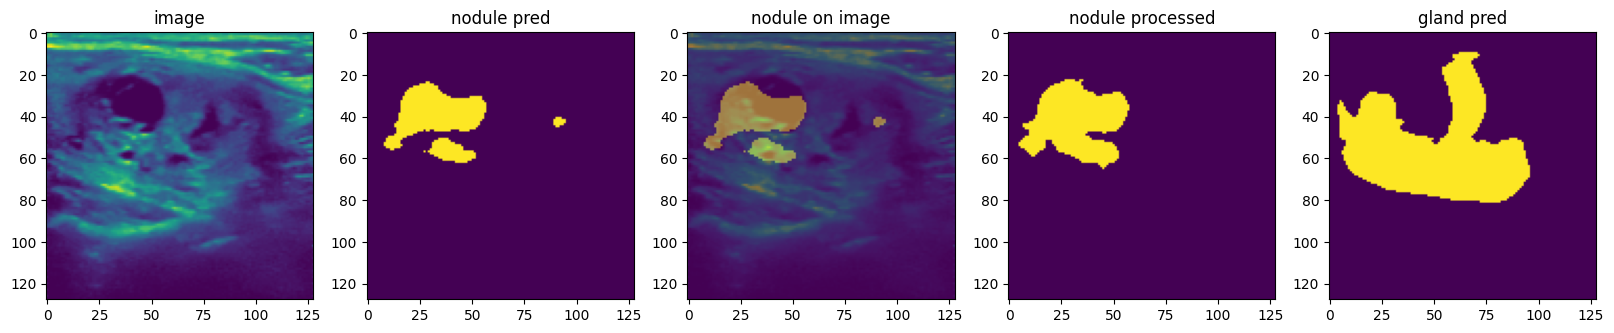

video_000041_1734078824312.MP4/155.png


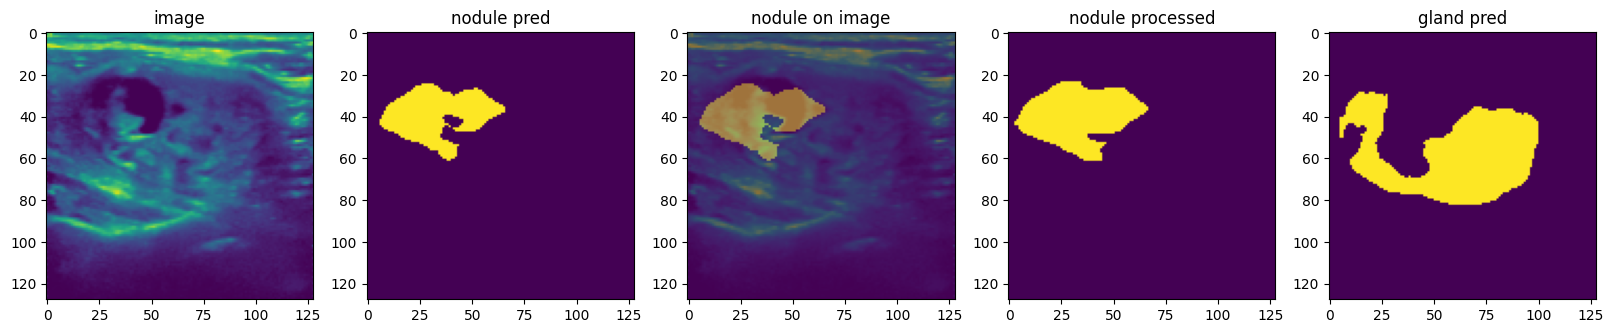

In [19]:
data_root = "crop_images"
video_name = "video_000041_1734078824312.MP4"
print(video_name)
image_dir = sorted(os.listdir(f"{data_root}/{video_name}"))
if '.ipynb_checkpoints' == image_dir[0]:
    image_dir = image_dir[1:]
image_dir = sorted(image_dir, key=lambda x: int(x.split('.')[0]))
print(len(image_dir))
count = 0

for i in (range(len(image_dir))):
    image_name = image_dir[i]
    if not "png" in image_name:
        continue
    image_path = f"{data_root}/{video_name}/{image_name}"
    image = Image.open(image_path).convert("L")

    resize = T.Resize((image_size, image_size))
    image = resize(image)

    image_tensor = tx.to_tensor(image)
    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    image = image_tensor.unsqueeze(0)
    image = image.to("cuda")
    output = model(image)
    
    nodule_output = output[:, 0:1]
    gland_output = output[:, 1:2]

    # nodule_output = torch.sigmoid(nodule_output)
    nodule_process = postprocess_logits_with_fill(nodule_output, 0.9)
    
    nodule_output = torch.sigmoid(nodule_output)
    nodule_output = nodule_output > 0.99

    gland_output = postprocess_logits_with_fill(gland_output, 0.9)
    gland_output = gland_output > 0.99
    
    # print(gland_output.shape)

    nodule_image = Image.fromarray(nodule_output[0][0].detach().cpu().numpy())
    gland_image = Image.fromarray(gland_output[0][0].detach().cpu().numpy())
    
    
    folder_name = "inference_mask_from_scratch_v3_2_aug_space(0.9)_weight_decay(1e-5)"
    video_path = f"{folder_name}/{video_name}/"
    nodule_path = f"{folder_name}/{video_name}/nodule/"
    gland_path = f"{folder_name}/{video_name}/gland/"
    combine_nodule_path = f"{folder_name}/{video_name}/combine_nodule/"
    combine_gland_path = f"{folder_name}/{video_name}/combine_gland/"
    
    # if not os.path.exists(nodule_path):
    os.makedirs(video_path, exist_ok=True)
    os.makedirs(nodule_path, exist_ok=True)
    os.makedirs(gland_path, exist_ok=True)
    os.makedirs(combine_nodule_path, exist_ok=True)
    os.makedirs(combine_gland_path, exist_ok=True)
        
    nodule_image.save(nodule_path + image_name)
    gland_image.save(gland_path + image_name)

    plt.imshow(image[0][0].detach().cpu().numpy())
    plt.imshow(nodule_output[0][0].detach().cpu().numpy(), alpha = 0.3)
    plt.axis('off')
    plt.savefig(f"{combine_nodule_path}/{image_name}", bbox_inches='tight', pad_inches=0)
    # plt.show()
    plt.close()

    plt.imshow(image[0][0].detach().cpu().numpy())
    plt.imshow(gland_output[0][0].detach().cpu().numpy(), alpha = 0.3)
    plt.axis('off')
    plt.savefig(f"{combine_gland_path}/{image_name}", bbox_inches='tight', pad_inches=0)
    # plt.show()
    plt.close()
    # break
    if count%5 == 0:
        print(video_name + "/" + image_name)
        plt.figure(figsize = (20, 20))
        plt.subplot(1,5,1)
        plt.imshow(image[0][0].detach().cpu().numpy())
        plt.title("image")
        plt.subplot(1,5,2)
        plt.imshow(nodule_output[0][0].detach().cpu().numpy())
        plt.title("nodule pred")
        
        plt.subplot(1,5,3)
        plt.imshow(image[0][0].detach().cpu().numpy())
        plt.imshow(nodule_output[0][0].detach().cpu().numpy(), alpha = 0.5)
        plt.title("nodule on image")
        
        plt.subplot(1,5,4)
        plt.imshow(nodule_process[0][0].detach().cpu().numpy())
        plt.title("nodule processed")
        plt.subplot(1,5,5)
        plt.imshow(gland_output[0][0].detach().cpu().numpy())
        plt.title("gland pred")
        plt.show()
    count+=1
    # if count > 30:
    #     break
    


In [9]:

data_root = "crop_images"
video_name = "video_000041_1734078135266.MP4"
image_dir = sorted(os.listdir(f"{data_root}/{video_name}"))
image_dir = sorted(image_dir, key=lambda x: int(x.split('.')[0]))
print((image_dir))

['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png'

In [9]:
image_dir


['.ipynb_checkpoints',
 '0.png',
 '1.png',
 '10.png',
 '100.png',
 '101.png',
 '102.png',
 '103.png',
 '104.png',
 '105.png',
 '106.png',
 '107.png',
 '108.png',
 '109.png',
 '11.png',
 '110.png',
 '111.png',
 '112.png',
 '113.png',
 '114.png',
 '115.png',
 '116.png',
 '117.png',
 '118.png',
 '119.png',
 '12.png',
 '120.png',
 '121.png',
 '122.png',
 '123.png',
 '124.png',
 '125.png',
 '126.png',
 '127.png',
 '128.png',
 '129.png',
 '13.png',
 '130.png',
 '131.png',
 '132.png',
 '133.png',
 '134.png',
 '135.png',
 '136.png',
 '137.png',
 '138.png',
 '139.png',
 '14.png',
 '140.png',
 '141.png',
 '142.png',
 '143.png',
 '144.png',
 '145.png',
 '146.png',
 '147.png',
 '148.png',
 '149.png',
 '15.png',
 '150.png',
 '151.png',
 '152.png',
 '153.png',
 '154.png',
 '155.png',
 '156.png',
 '157.png',
 '158.png',
 '159.png',
 '16.png',
 '160.png',
 '161.png',
 '162.png',
 '163.png',
 '164.png',
 '165.png',
 '166.png',
 '167.png',
 '17.png',
 '18.png',
 '19.png',
 '2.png',
 '20.png',
 '21.png',